# Homework 5 - Deep Learning

## Задание 7

Модифицируйте свою лучшую модель из 4-го занятия 10-го задания, добавьте в нее **skip-connection**. Обучите ее на `CIFAR10`. Сравните качество со **skip-connection** и без skip-connection. Добейтесь Accuracy в 91.5% на тестовой выборке.

Чтобы добавить skip-connection в модель, нам нужны сверточные слои, которые принимают на вход C каналов и возвращают C каналов. Тогда в forward для блока из такого сверточного слоя, батч-нормализации и функции активации skip-connection будет выглядеть вот так:

```python
...
x = self.block(x) + x
...
```

Вам нужно сдать код с функцией, которая возвращает модель, назовите эту функцию `create_advanced_skip_connection_conv_cifar`. Она не принимает аргументов и возвращает объект модели.

Также сдайте предсказание для тестовой выборки датасета `CIFAR10`. Воспользуйтесь `torch.save` для записи тензора с результатом предсказания на диск.

### Импорт библиотек

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision.datasets import CIFAR10
from torchvision.models import alexnet, vgg11, googlenet, resnet18
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

import importlib
task5 = importlib.import_module("5 - Architects")
task4 = importlib.import_module("4 - RegularizeConvNet")
task3 = importlib.import_module("3 - ConvNets")
task2 = importlib.import_module("2 - NeuralOptim")

%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

plt.rc('font', size=20)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


### Импорт датасета

Прежде чем создавать тренировочные и тестовые батчи датасета, для начала определим преобразования для него. Для этого нам может пригодиться знание среднего и стандартного отклонения по датасету

In [2]:
cifar_train = CIFAR10(
    "../../datasets/cifar",
    train=True,
    download=True,
    transform=T.ToTensor()  # чтобы переводился сразу в тензорный объект
)

Files already downloaded and verified


In [3]:
means = (cifar_train.data / 255).mean(axis=(0, 1, 2)) # делим на 255, чтобы значения признаков лежали в [0, 1]
std = (cifar_train.data / 255).std(axis=(0, 1, 2))


In [4]:
# применим функцию с преобразованиями

def get_augmentations(means: float, std: float, train: bool = True) -> T.Compose:
    if train:
        return T.Compose(
            [
                T.AutoAugment(T.AutoAugmentPolicy.CIFAR10),
                T.ToTensor(),
                T.Normalize(mean=means, std=std)
            ]
        )
    else:
        return T.Compose(
            [
                T.ToTensor(),
                T.Normalize(mean=means, std=std)
            ]
        )


In [5]:
# создадим loader для трейна и теста

train_dataset = CIFAR10(
    "../../datasets/cifar",
    train=True,
    download=False,
    transform=get_augmentations(means=means, std=std, train=True) 
)

test_dataset = CIFAR10(
    "../../datasets/cifar",
    train=False,
    download=True,
    transform=get_augmentations(means=means, std=std, train=False)
)


Files already downloaded and verified


In [6]:
train_loader = DataLoader(train_dataset, batch_size=512,
                          shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512,
                          shuffle=False, num_workers=8, pin_memory=True)

### Соберем служебные функции

В этом разделе подготовим функции, которые будут обучать модель, замерять качество модели, делать предсказания, и, наконец, визуализировать обучение модели

In [7]:
# функция обучения
def train(model: nn.Module, data_loader: DataLoader, optimizer: torch.optim.Optimizer, loss_fn):
    model.to(device)
    model.train()
    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc='Training'):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()  # zeroing gradients
        output = model(x)  # forward pass
        loss = loss_fn(output, y)  # count loss
        total_loss += loss.item()  # writing current loss
        loss.backward()  # backward pass
        # print(round(loss.item(), 5))  # print current loss
        optimizer.step()  # optimization step
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()
    total_loss /= len(data_loader)
    accuracy = correct / total

    return total_loss, accuracy


In [8]:
# функция оценки качества
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader) -> tuple:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [9]:
# Функция предсказания
@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    model.to(device)
    model.eval()
    predictions = []
    for x, y in tqdm(loader, desc='Prediction'):
        x, y = x.to(device), y.to(device)
        output = model(x)
        predictions.append(torch.argmax(output, axis=1))
    return torch.concat(predictions)


In [10]:
# функция визуализации
def plot_stats(
    train_loss: list,
    valid_loss: list,
    train_accuracy: list,
    valid_accuracy: list,
    title: str,
    lr=None
):
    # loss 
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()


    if lr:
        plt.figure(figsize=(16, 8))
        
        plt.title(title + 'Learning Rate')
        plt.plot(lr, label='Learning Rate')
        plt.grid()

        plt.show()




### Соберем модель

Ранее наша модель выглядела так:

In [11]:
def create_advanced_conv_cifar():
    return nn.Sequential(  # 32x32
        nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16

        nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8

        nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2),  # 4x4

        nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2),  # 2x2

        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2),  # 1x1

        nn.Flatten(),

        nn.Linear(512, 10)

    )


Теперь в нашу модель требуется добавление skip_connection в тех блоках слоев, где кол-во входов равно количеству выходов. У нас таких блоков 4: 1 с 256 входами, и 3 с 512

Для применения кастомного forward надо переписать функцию как класс

In [12]:
class AdvancedCifarModel(nn.Module):
    def _make_conv_block(self, in_features, out_features):
        return nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(out_features),
            nn.ReLU()
        )
    
    def _make_pooling(self):
        return nn.MaxPool2d(kernel_size=2, stride=2)

    def __init__(self):
        super().__init__()
        self.conv_1 = self._make_conv_block(3, 64)
        self.pool_1 = self._make_pooling()
        self.conv_2 = self._make_conv_block(64, 128)
        self.pool_2 = self._make_pooling()
        self.conv_3 = self._make_conv_block(128, 256)
        self.conv_4 = self._make_conv_block(256, 256)
        self.pool_3 = self._make_pooling()
        self.conv_5 = self._make_conv_block(256, 512)
        self.conv_6 = self._make_conv_block(512, 512)
        self.pool_4 = self._make_pooling()
        self.conv_7 = self._make_conv_block(512, 512)
        self.conv_8 = self._make_conv_block(512, 512)
        self.pool_5 = self._make_pooling()
        self.flat = nn.Flatten()
        self.linear = nn.Linear(512, 10)
    
    def forward(self, x):
        y = self.conv_1(x)
        y = self.pool_1(y)
        y = self.conv_2(y)
        y = self.pool_2(y)
        y = self.conv_3(y)
        y = self.conv_4(y) + y
        y = self.pool_3(y)
        y = self.conv_5(y)
        y = self.conv_6(y) + y
        y = self.pool_4(y)
        y = self.conv_7(y) + y
        y = self.conv_8(y) + y
        y = self.pool_5(y)
        y = self.flat(y)
        y = self.linear(y)
        return y

In [14]:
# Создаем модель
model = AdvancedCifarModel()

# Зададим функцию ошибки и оптимизатор
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)


In [15]:

oc_scheduler = OneCycleLR(optimizer=optimizer, max_lr=0.01,
                          epochs=30, steps_per_epoch=len(train_loader))

Попробуем обучить модель с помощью планировщика OneCycle

Также добавим подрезку градиента и weight decay

In [13]:
def whole_train_valid_cycle_with_oc_scheduler(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []
    lr_history = []

    for epoch in range(num_epochs):
        model.to(device)
        model.train()
        train_loss = 0
        total = 0
        correct = 0

        for x, y in tqdm(train_loader, desc='Training'):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()  # zeroing gradients
            output = model(x)  # forward pass
            loss = loss_fn(output, y)  # count loss
            train_loss += loss.item()  # writing current loss
            loss.backward()  # backward pass
            nn.utils.clip_grad_value_(model.parameters(), 0.1) # add  gradient clipping
            optimizer.step()  # optimization step
            _, y_pred = torch.max(output, 1)
            total += y.size(0)
            correct += (y_pred == y).sum().item()
            oc_scheduler.step()  # adding scheduler in batch cycle
            lr_history.append(optimizer.param_groups[0]['lr'])
        train_loss /= len(train_loader)
        train_accuracy = correct / total

        valid_loss, valid_accuracy = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title, lr=lr_history
        )


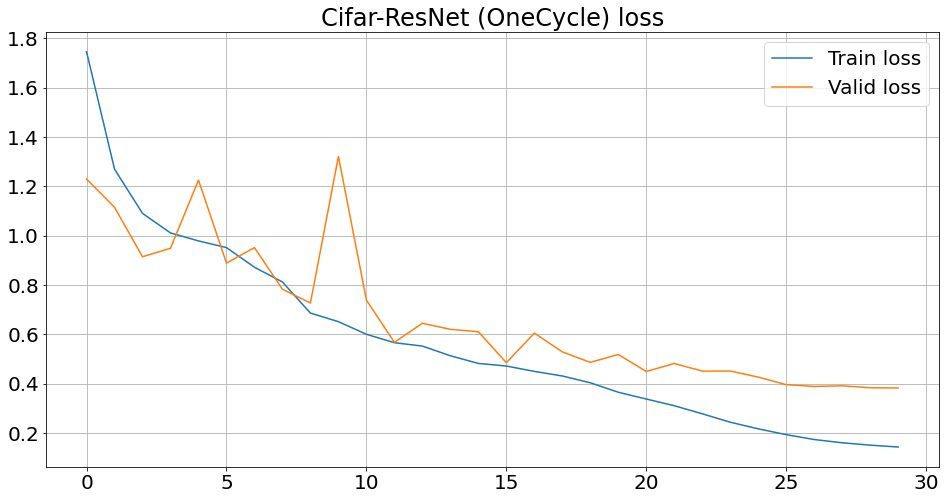

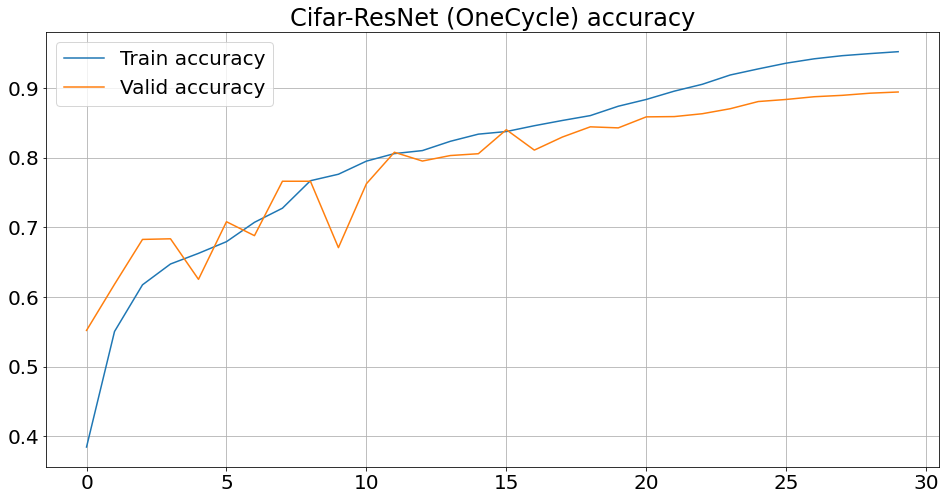

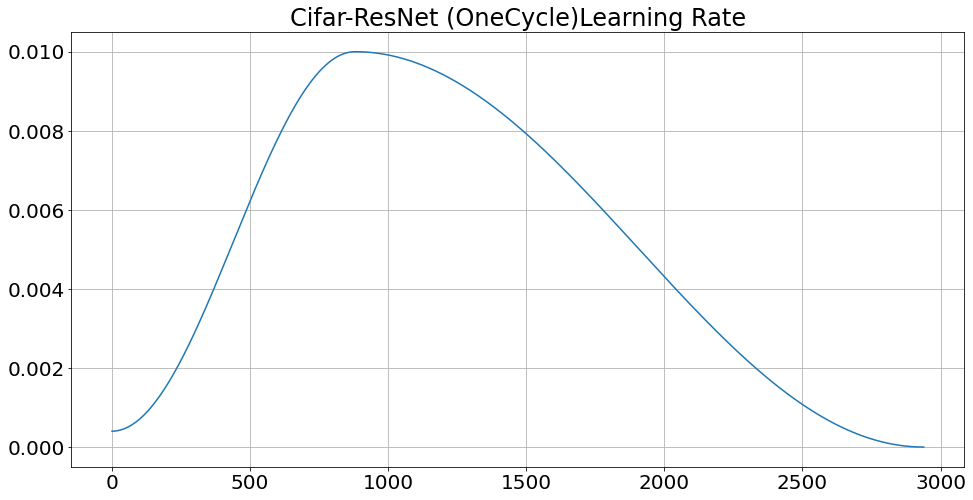

In [17]:
whole_train_valid_cycle_with_oc_scheduler(model, 30, 'Cifar-ResNet (OneCycle)')

In [18]:
preds = predict(model, test_loader, device)

Prediction: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


In [19]:
# сохраним предсказания на диск
torch.save(preds, 'cifar_skip.pkl')

In [20]:
torch.save(model.state_dict(), 'cifar1_state_dict')


In [21]:
# чтобы сделать reset параметров:
for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

Попробуем обучить и с помощью plateau-планировщика

In [14]:
# Создаем модель
model_2 = AdvancedCifarModel()

# Зададим функцию ошибки и оптимизатор
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_2.parameters(), lr=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7)

In [15]:
def whole_train_valid_cycle_with_plateau_scheduler(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []
    lr_history = []
    scheduler.last_epoch = num_epochs

    for epoch in range(num_epochs):
        model.to(device)
        model.train()
        train_loss = 0
        total = 0
        correct = 0

        for x, y in tqdm(train_loader, desc='Training'):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()  # zeroing gradients
            output = model(x)  # forward pass
            loss = loss_fn(output, y)  # count loss
            train_loss += loss.item()  # writing current loss
            loss.backward()  # backward pass
            nn.utils.clip_grad_value_(model.parameters(), 0.1) # add  gradient clipping
            optimizer.step()  # optimization step
            _, y_pred = torch.max(output, 1)
            total += y.size(0)
            correct += (y_pred == y).sum().item()
        train_loss /= len(train_loader)
        train_accuracy = correct / total

        train_loss, train_accuracy = train(
            model, train_loader, optimizer, loss_fn)
        valid_loss, valid_accuracy = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        lr_history.append(optimizer.param_groups[0]['lr'])

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title, lr=lr_history
        )

        scheduler.step(metrics=valid_loss)


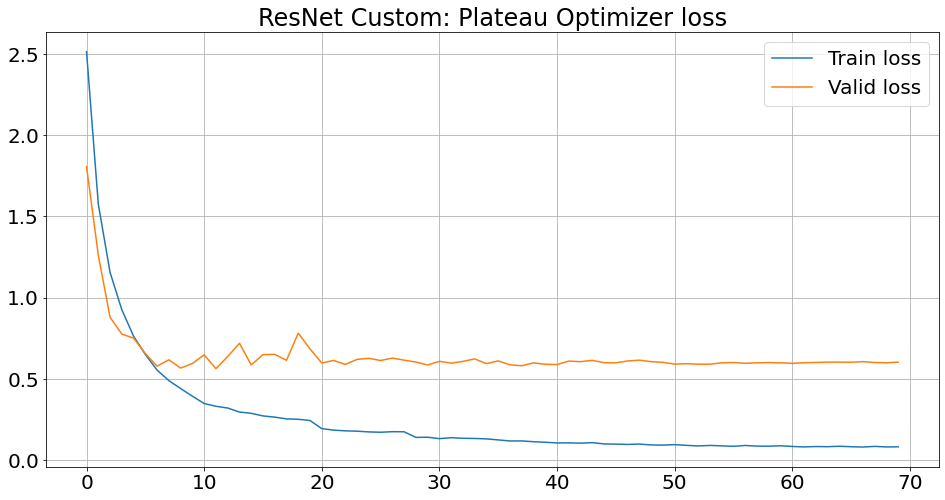

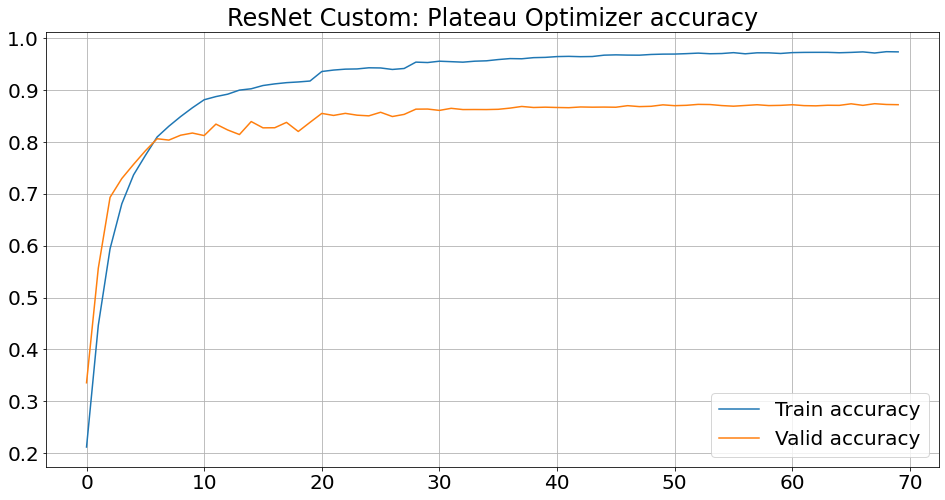

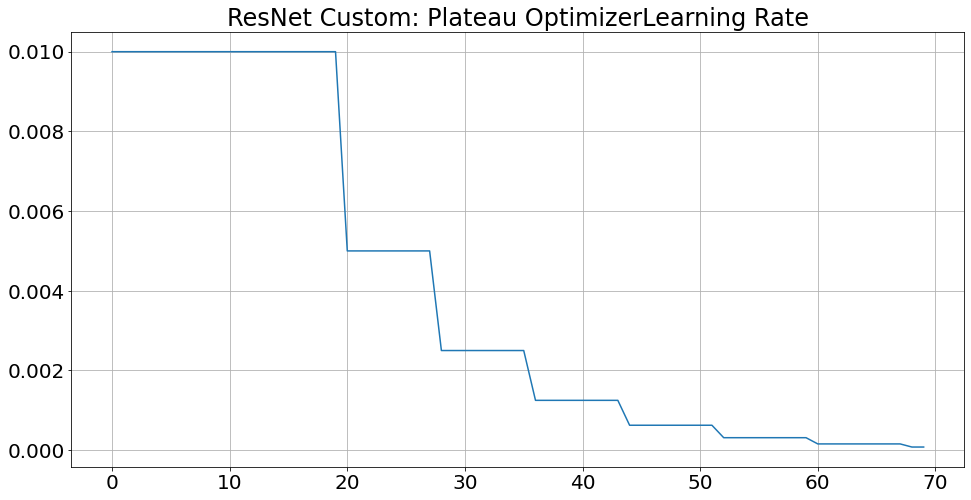

In [24]:
whole_train_valid_cycle_with_plateau_scheduler(
    model_2, 70, 'ResNet Custom: Plateau Optimizer')


In [25]:
torch.save(model_2.state_dict(), 'cifar2_state_dict')

Видимо, натянув втупую residual layers на нейросеть, мы не получим улучшение из коробки.

Попробуем переписать архитектуру сети. например, заменим ее на ResNet-9

In [16]:
class ResNet9(nn.Module):
    def _make_conv_block(self, in_features, out_features):
        return nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(out_features),
            nn.ReLU()
        )
    
    def _make_pooling(self, size=2):
        return nn.MaxPool2d(kernel_size=size, stride=size)

    def __init__(self):
        super().__init__() # 32x32x3
        self.conv_1 = self._make_conv_block(3, 64) #32x32x64
        self.conv_2 = nn.Sequential(
            self._make_conv_block(64, 128),
            self._make_pooling()
        ) # 16x16x128
        self.res_1 = nn.Sequential(
            self._make_conv_block(128, 128),
            self._make_conv_block(128, 128)
        )  # 16x16x128
        self.conv_3 = nn.Sequential(
            self._make_conv_block(128, 256),
            self._make_pooling()
        ) # 8x8x256
        self.conv_4 = nn.Sequential(
            self._make_conv_block(256, 512),
            self._make_pooling()
        ) # 4x4x512
        self.res_2 = nn.Sequential(
            self._make_conv_block(512, 512),
            self._make_conv_block(512, 512)
        ) # 4x4x512
        self.clas = nn.Sequential(
            self._make_pooling(4), # 1x1x512
            nn.Flatten(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        out = self.conv_1(x)
        out = self.conv_2(out)
        out = self.res_1(out) + out
        out = self.conv_3(out)
        out = self.conv_4(out)
        out = self.res_2(out) + out
        out = self.clas(out)
        return out


In [29]:
# Создаем модель
model_3 = ResNet9()

# Зададим функцию ошибки и оптимизатор
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_3.parameters(), lr=1e-2, weight_decay=1e-4)


In [30]:
oc_scheduler = OneCycleLR(optimizer=optimizer, max_lr=0.01, pct_start=0.3,
                          epochs=70, steps_per_epoch=len(train_loader))

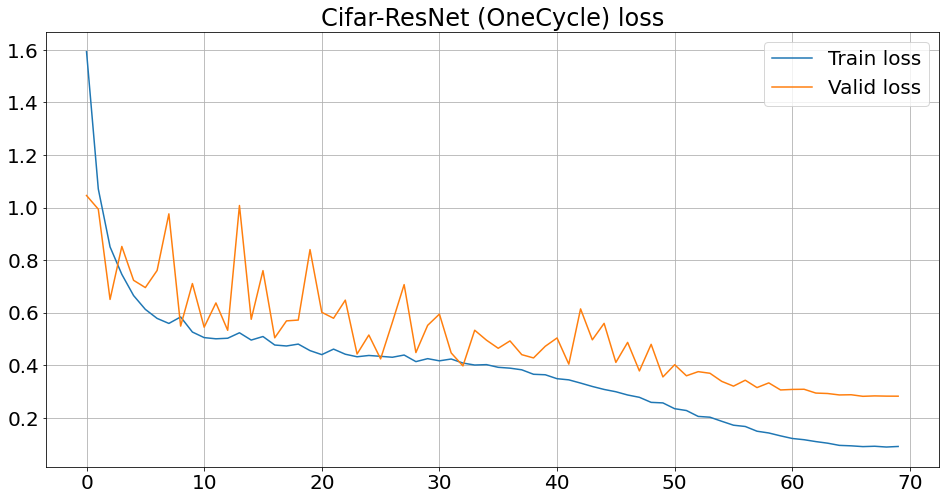

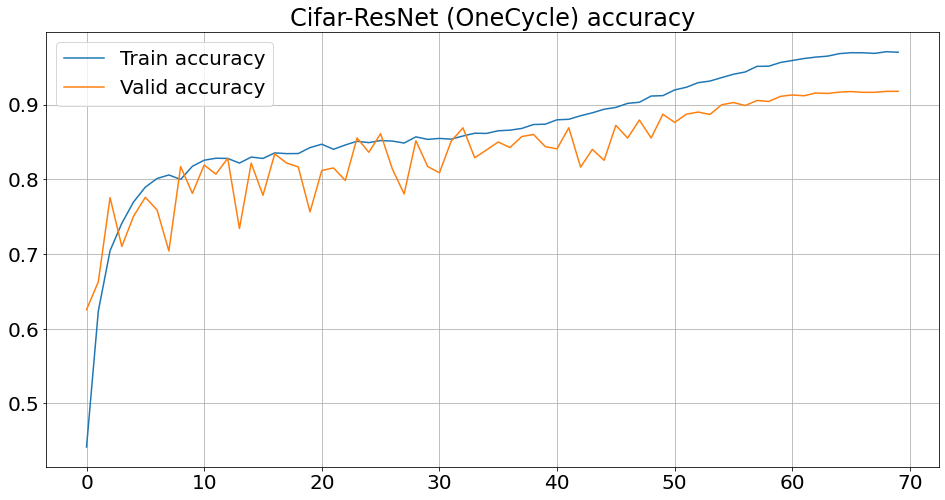

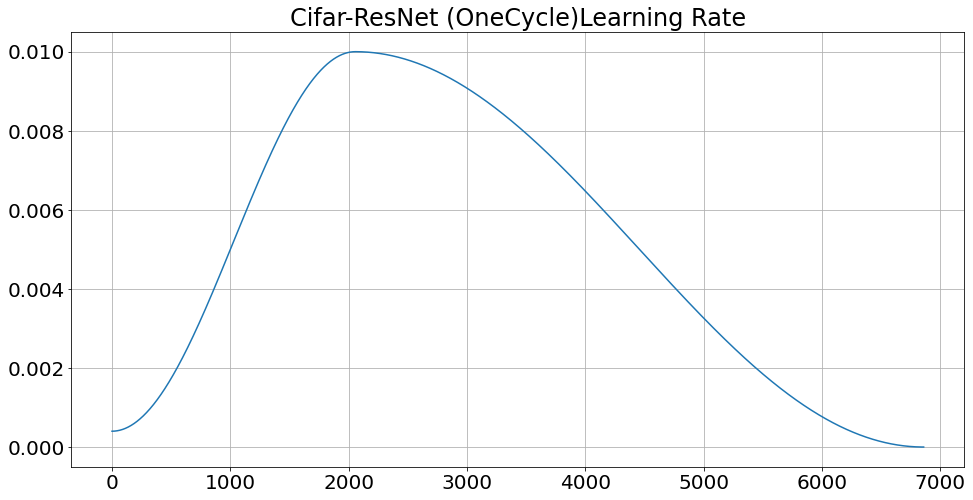

In [31]:
torch.cuda.empty_cache()

whole_train_valid_cycle_with_oc_scheduler(model_3, 70, 'Cifar-ResNet (OneCycle)')


In [32]:
evaluate(model_3, test_loader)

Evaluation: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


(0.2823380634188652, 0.9178)

In [33]:
preds = predict(model_3, test_loader, device)


Prediction: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


In [35]:
# сохраним предсказания на диск
torch.save(preds, 'cifar_hw5.pkl')


In [ ]:
# Дообучим на мелком шаге градиента
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7)


In [ ]:
whole_train_valid_cycle_with_plateau_scheduler(
    model_3, 20, 'ResNet-9: Plateau Optimizer')
